In [30]:
import json
import os
import pickle

import numpy as np
from skimage import feature, io, transform, util, filters, morphology
from sklearn import model_selection

In [31]:
DATA_DIRECTORY = "data"
MEN_DIRECTORY = os.path.join(DATA_DIRECTORY, "men")
WOMEN_DIRECTORY = os.path.join(DATA_DIRECTORY, "women")
LABELS_FILENAME = os.path.join(DATA_DIRECTORY, "labels.jsonl")

In [32]:
paths: list[str] = []
labels: list[int] = []
with open(LABELS_FILENAME, "r") as f:
    for line in f:
        entry = json.loads(line)
        path = entry["image_url"]
        label = int(entry["label"])
        paths.append(path)
        labels.append(label)

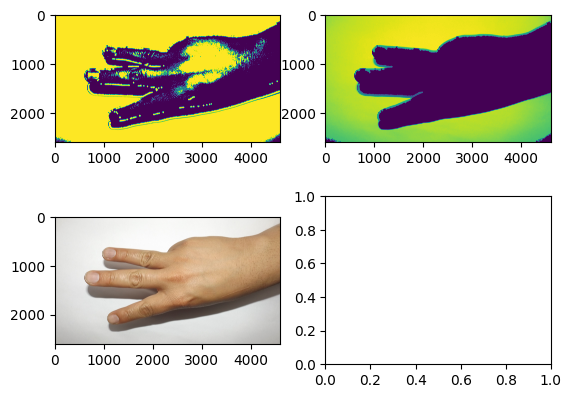

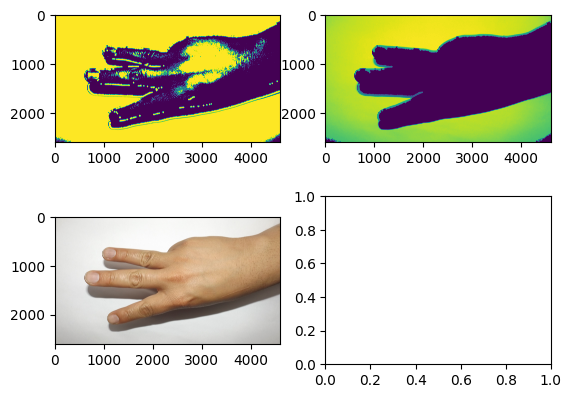

In [52]:
def segment_hand(path: np.ndarray) -> np.ndarray:
    grayscale = io.imread(path, as_gray=True)

    # Apply a threshold
    threshold = filters.threshold_otsu(grayscale)
    binary = image > threshold

    # # Remove shadow
    # shadow_mask = filters.threshold_local(grayscale, 101)
    # shadow_mask = np.uint8(grayscale > shadow_mask)
    # shadow_mask = morphology.binary_closing(shadow_mask, morphology.disk(15))
    # grayscale_no_shadow = np.where(shadow_mask, grayscale, 1)

    # # Apply a threshold
    # threshold = filters.threshold_otsu(grayscale_no_shadow)
    # binary = grayscale_no_shadow > threshold

    # Remove small objects
    cleaned = morphology.remove_small_objects(binary, min_size=64, connectivity=2)

    # Fill holes
    filled = morphology.remove_small_holes(cleaned, area_threshold=64, connectivity=2)

    # Label regions
    labels = morphology.label(filled)

    # Find the largest region
    largest_region = 0
    largest_size = 0
    for region in range(1, np.max(labels) + 1):
        size = np.sum(labels == region)
        if size > largest_size:
            largest_size = size
            largest_region = region

    # Extract the hand
    hand = np.zeros_like(image)
    hand[labels == largest_region] = image[labels == largest_region]

    return hand

In [ ]:
N = 20
# Sample N images from each class
classes = np.unique(labels)
sampled_paths = []
sampled_labels = []
for c in classes:
    class_paths = [p for p, l in zip(paths, labels) if l == c]
    sampled_paths.extend(class_paths[:N])
    sampled_labels.extend([c] * N)

paths = sampled_paths
labels = sampled_labels

In [ ]:
from hog import hog

myhog = hog
skhog = feature.hog


def get_features(img_path: str) -> np.ndarray:
    img = util.img_as_float(io.imread(img_path, as_gray=True))

    img = transform.rescale(img, 1 / 16)

    # features = myhog(img)
    features = skhog(
        img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)
    )

    return features

In [ ]:
features = [get_features(path) for path in paths]

In [ ]:
with open("features.pkl", "wb") as f:
    pickle.dump(features, f)

In [ ]:
# with open("features.pickle", "rb") as f:
# features = pickle.load(f)

In [ ]:
random_state = 312

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    features, labels, test_size=0.2, random_state=random_state
)

In [ ]:
cv = model_selection.StratifiedKFold(
    n_splits=5, shuffle=True, random_state=random_state
)

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel="linear")

result = model_selection.cross_validate(
    clf,
    X_train,
    y_train,
    cv=cv,
    scoring=("accuracy", "balanced_accuracy"),
)

result

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [ ]:
# with open("model.pkl", "rb") as f:
#     clf = pickle.load(f)

In [ ]:
clf.score(X_test, y_test)